# Adaption der Objektextraktion
Object Abstraction Original Script von Beat Tödtli 
https://www.kaggle.com/code/toedtlifhsg/giraffenpuzzle-objektextraktion

In [1]:
# ============================================================================
# SCHRITT 1: LADE ALLE SCRIPTS
# ============================================================================
# Dies muss zuallererst ausgeführt werden, damit alle Funktionen verfügbar sind
# Alle Vorbereitungsfunktionen sind in scripts/semesterarbeit_preparation.py ausgelagert

# ============================================================================
# IMPORTS - Alle benötigten Bibliotheken
# ============================================================================
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shutil
import zipfile
from IPython.display import FileLink
# Füge das ÜBERGEORDNETE Verzeichnis zum Python-Pfad hinzu (muss vor dem Import sein)
# Damit funktioniert 'from scripts.xxx import ...'
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

# Importiere die Vorbereitungsfunktionen
from scripts.semesterarbeit_preparation import setup_environment

# Führe alle Vorbereitungsschritte aus
# Dies prüft Module, lädt Scripts und Config
setup_result = setup_environment(install_missing_modules=True)

# Extrahiere Funktionen und Parameter
functions = setup_result['functions']
params = setup_result['params']

# Setze alle Parameter-Variablen für einfachen Zugriff
config = params['config']
extraction_config = params['extraction_config']
pr = params['pr']
fr = params['fr']
fc = params['fc']
vth = params['vth']
es = params['es']
ds = params['ds']
mpx = params['mpx']
saturation_threshold = params['saturation_threshold']
value_threshold = params['value_threshold']
Bilddateiendung = params['bilddateiendung']
fv = params['fv']

# Stelle alle Funktionen global zur Verfügung
choose_an_image = functions['choose_an_image']
resize_image = functions['resize_image']
fill_borders = functions['fill_borders']
create_mask_from_image = functions['create_mask_from_image']
apply_morphology = functions['apply_morphology']
extract_objects = functions['extract_objects']
filter_small_objects = functions['filter_small_objects']
print_region_sizes = functions['print_region_sizes']

# Stelle object_extraction Modul zur Verfügung
object_extraction = functions['object_extraction']
# Importiere häufig verwendete Funktionen aus object_extraction
from object_extraction import process_file, image_preprocessing, save_regionlist_to_folder, generate_mask_with_hsv_threshold, create_masked_image, create_mask, extract_regions

# Hilfsfunktion zum Anzeigen von Bildern
def show_image(image, show_colorbar=False):
    """Zeigt ein Bild an (NumPy Array oder PIL Image)"""
    if hasattr(image, 'shape'):  # NumPy Array
        im = plt.imshow(image)
    else:  # PIL Image
        im = plt.imshow(np.array(image))
    plt.axis('off')
    if show_colorbar:
        plt.colorbar(im)
    plt.show()

# Funktion zur Visualisierung von Regionen
def visualize_regions(regions):
    """
    Visualisiert die extrahierten Regionen.
    
    Args:
        regions: Liste von RegionProps-Objekten (z.B. regions1, regions2, etc.)
    """
    if len(regions) < 10:
        for ireg, reg in enumerate(regions):
            print(f"Region {ireg}: {int(reg.area):>6}")
            # Zeige jede Region als Bild (wie im Original)
            plt.figure()
            plt.imshow(reg.image_intensity)
            plt.xticks([])
            plt.yticks([])  # Wir brauchen keine x- und y-Achse
            plt.title(f"Region {ireg}: {int(reg.area)} Pixel")
        # Zeige auch bei wenigen Regionen ein Histogramm
        plt.figure()
        plt.hist([reg.area for reg in regions], bins=np.logspace(1, 6, 100))
        plt.gca().set_xscale('log')  # ev. sieht man damit etwas mehr
        plt.gca().set_yscale('log')
        plt.title("Verteilung der Region-Größen")
        plt.show()
    else:
        # for ireg,reg in enumerate(regions):
        #     print(f"{int(reg.area):<3} ",end='')
        
        plt.hist([reg.area for reg in regions], bins=np.logspace(1, 6, 100))
        plt.gca().set_xscale('log')  # ev. sieht man damit etwas mehr
        plt.gca().set_yscale('log')
        plt.show()  # Zeige das Histogramm an

# Funktion zum Filtern und Anzeigen relevanter Regionen
def show_relevant_regions(regions, min_pixels=None):
    """
    Filtert und zeigt relevante Regionen an (Regionen mit mindestens min_pixels Pixeln).
    
    Args:
        regions: Liste von RegionProps-Objekten (z.B. regions1, regions2, etc.)
        min_pixels: Mindestanzahl Pixel pro Region. Wenn None, wird mpx verwendet.
    """
    # Verwende mpx als Standard, falls min_pixels nicht angegeben
    if min_pixels is None:
        min_pixels = mpx
    
    # Filtere relevante Regionen
    relevante_regionen = [reg for reg in regions if reg.area >= min_pixels]
    
    if len(relevante_regionen) == 0:
        print(f"Keine Regionen mit >= {min_pixels} Pixeln gefunden. Zeige alle Regionen:")
        relevante_regionen = regions  # Zeige alle Regionen, wenn keine gefilterten gefunden wurden
    
    if len(relevante_regionen) < 20:
        for reg in relevante_regionen:
            plt.figure()
            plt.imshow(reg.image_intensity)
            plt.xticks([])
            plt.yticks([])  # Wir brauchen keine x- und y-Achse
        plt.show()  # Zeige alle Bilder an
    else:
        print(f"Das würde {len(relevante_regionen)} Graphiken erzeugen! Ich mache lieber nichts...")
    
    return relevante_regionen

print("\n✓ Alle Vorbereitungsschritte abgeschlossen!")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\dev\anaconda\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\dev\anaconda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\dev\anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "d:\dev\anaconda\Lib\site-packages\tornado\platform\asyncio.py", l

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\dev\anaconda\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\dev\anaconda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\dev\anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "d:\dev\anaconda\Lib\site-packages\tornado\platform\asyncio.py", l

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# ============================================================================
# SCHRITT 2: ZEIGE CONFIG PARAMETER
# ============================================================================
# Die Config wurde bereits in Schritt 1 geladen
# Hier werden nur die Parameter angezeigt

import importlib
import sys

# Lade das Modul neu, falls es bereits geladen wurde
if 'scripts.semesterarebeit_object_extraktion' in sys.modules:
    importlib.reload(sys.modules['scripts.semesterarebeit_object_extraktion'])

from scripts.semesterarebeit_object_extraktion import print_extraction_parameters

# Zeige die geladenen Parameter an (übergib das Config-Objekt)
print_extraction_parameters(config)

print("\n✓ Config-Parameter angezeigt!")


Parameter für Objektextraktion:
  Auflösung: Längere Seite = 400px (proportional)
  Value Threshold: 150
  Minimum Pixel: 2000
  Erosion/Dilatation: 0/5 ( Minimale Transformation, da ursprüngliche Maske besser ist!)

✓ Config-Parameter angezeigt!


## Setup und Zugriff zu den Bilddaten

In [ ]:
# Zeige Inhalt des data-Verzeichnisses
from scripts.semesterarebeit_object_extraktion import list_data

list_data()

Inhalt von 'd:\dev\git\privat\Studium\dsci-semesterarebeit\data':
  - schraubenschluessel
  - schraubenzieher
  - seidenschneider


Wenn das geklappt hat, haben Sie Zugriff auf die Daten! In der nächsten Zelle muss einfach der Pfad richtig angepasst werden. Dann sind Sie gerüstet für den Rest des Notebooks. Kopieren Sie jenen Pfad als String in die folgende Variable:

Als nächstes benötigen wir den Pfad zu `lcl_colab/1_object_extraction`. Er muss in sys.path zu finden sein. In der nächsten Zelle wird dies getestet:

Alle scrpte und Importe sind geladen. 

Laden wir ein Bild aus jedem unserer Klassen Ordner. 

Inhalt von data:
- d:\dev\git\privat\Studium\dsci-semesterarebeit\data\schraubenschluessel
- d:\dev\git\privat\Studium\dsci-semesterarebeit\data\schraubenzieher
- d:\dev\git\privat\Studium\dsci-semesterarebeit\data\seidenschneider

BEISPIELBILDER AUS JEDEM ORDNER
Gewählte Klasse: schraubenschluessel
Datei: IMG_2127.JPEG
Gewählte Klasse: schraubenzieher
Datei: IMG_1884.JPEG
Gewählte Klasse: seidenschneider
Datei: IMG_2011.JPEG


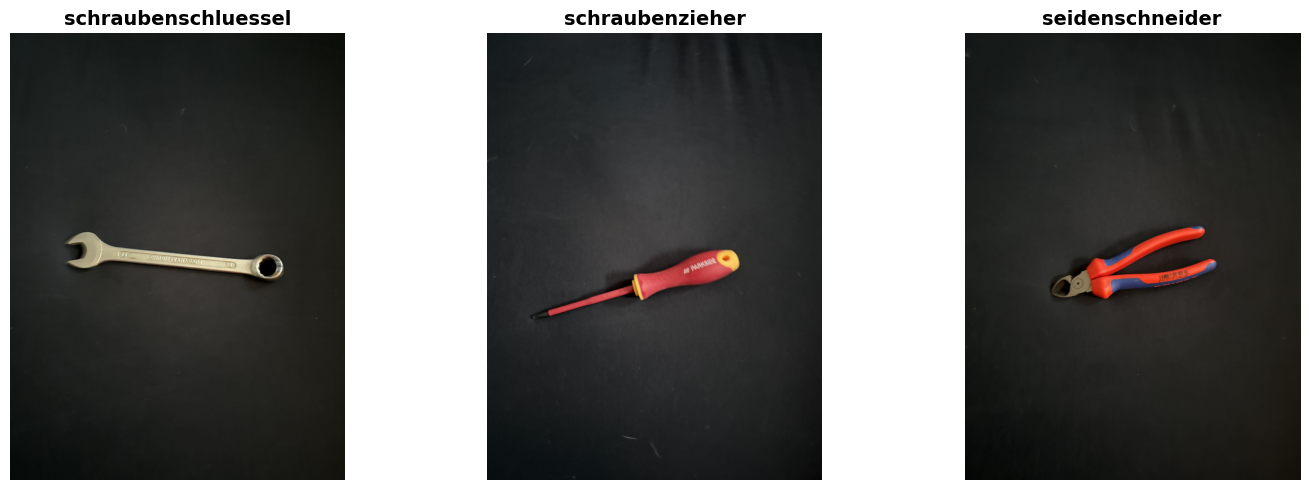


✓ 3 Beispielbilder geladen und angezeigt!


In [ ]:
# Importiere die aktualisierte Funktion
from pathlib import Path
import os
import matplotlib.pyplot as plt
from scripts.schritt0_bild_laden import choose_an_image

base_path = Path(os.getcwd()) / "data"
dataset_paths = {
    "schraubenschluessel": base_path / "schraubenschluessel",
    "schraubenzieher": base_path / "schraubenzieher",
    "seidenschneider": base_path / "seidenschneider"
}

print("Inhalt von data:")
if base_path.exists():
    for p in base_path.iterdir():
        print("-", p)
else:
    print(f"Warnung: Verzeichnis {base_path} existiert nicht!")

# Lade für jeden Ordner ein Beispielbild
print("\n" + "="*70)
print("BEISPIELBILDER AUS JEDEM ORDNER")
print("="*70)

im1, klasse1 = choose_an_image(dataset_paths, klasse_name="schraubenschluessel")
im2, klasse2 = choose_an_image(dataset_paths, klasse_name="schraubenzieher")
im3, klasse3 = choose_an_image(dataset_paths, klasse_name="seidenschneider")

# Zeige alle Bilder nebeneinander
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(im1)
axes[0].set_title(klasse1, fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(im2)
axes[1].set_title(klasse2, fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(im3)
axes[2].set_title(klasse3, fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ 3 Beispielbilder geladen und angezeigt!")


# Parameteranpassung für die Objektextraktion

Wir haben Zugriff auf die Bilddaten. Nun werden die Parameterwerte ausgewählt, welche die Objekte gut vom Hintergrund isolieren. Die Funktion `process_file` führt die komplette Verarbeitung durch.

Das Vorgehen besteht aus folgenden Schritten:

1. **Auflösungsreduktion**: Das Bild wird verkleinert, um die Rechenzeit zu reduzieren. Der Parameter **`pr`** gibt die maximale Seitenlänge in Pixeln an (z.B. 400px). Die Proportionen des Bildes werden dabei beibehalten.

2. **Ränder abschneiden** (optional): An den Rändern kann ein Prozentsatz der Zeilen bzw. Spalten abgeschnitten werden, um Artefakte zu beseitigen. Der Prozentsatz der Zeilen wird durch **`fr`**, jener der Spalten durch **`fc`** festgelegt. Die abgeschnittenen Bereiche werden mit dem Wert **`fv`** (value_to_fill) aufgefüllt.

3. **Hintergrundschwellwert**: Ein Schwellwert wird auf den Value-Kanal im HSV-Farbraum angewendet, um den Hintergrund vom Objekt zu trennen. Der Parameter **`vth`** (value_threshold) bestimmt den Schwellwert. Dies ergibt eine binäre Maske, welche die Vordergrundpixel (Objekt) identifiziert.

4. **Morphologische Transformation**: Kleine Artefakte auf der Maske werden durch morphologische Operationen entfernt oder verbessert. Der Parameter **`es`** (erosion_size) gibt die Größe des Erosionskerns an, **`ds`** (dilation_size) die Größe des Dilatationskerns. Erosion entfernt kleine Störungen, Dilatation füllt kleine Lücken.

5. **Objekte extrahieren**: Separate Objekte werden in der Maske identifiziert. Dazu werden verbundene Komponenten gelabelt und für jedes Objekt eine Bounding Box erstellt.

6. **Kleine Objekte filtern**: Objekte mit weniger als **`mpx`** (minimum_pixels) Pixeln werden verworfen. Dies filtert Reflexionen und andere kleine Artefakte, die kein vollständiges Objekt darstellen.

7. **Speichern**: Für jedes gefundene Objekt wird ein neues Bild gespeichert, welches nur noch das ausgeschnittene Objektelement enthält.

Wenn dies erfolgreich ist, sind die Bilder in einer geeigneten Form für das Training eines Deep-Learning-Modells.

Im Folgenden wird dieser Vorgang Schritt für Schritt für Beispielbilder durchgeführt. Die Parameter können in der Konfigurationsdatei angepasst werden.


### Schritt: Laden der Bilder

Die Bilder haben aktuell folgende Auflösungen

In [ ]:
np_im = np.array(im1)
print(klasse1)
print("Shape:", np_im.shape)
print("Size:", im1.size)
print("Mode:", im1.mode)
print("")
print("------------")
print(klasse2)
print("Shape:", np_im.shape)
print("Size:", im2.size)
print("Mode:", im2.mode)
print("")
print("------------")
print(klasse3)
print("Shape:", np_im.shape)
print("Size:", im3.size)
print("Mode:", im3.mode)
print("")
print("------------")

schraubenschluessel
Shape: (2048, 1536, 3)
Size: (1536, 2048)
Mode: RGB

------------
schraubenzieher
Shape: (2048, 1536, 3)
Size: (1536, 2048)
Mode: RGB

------------
seidenschneider
Shape: (2048, 1536, 3)
Size: (1536, 2048)
Mode: RGB

------------


### Schritt 1: Auflösungsreduktion

Die Bilder können zu hoch aufgelöst sein für unsere Anwendung, wodurch sich die Rechenzeit der folgenden Operationen vervielfacht. Die Vorverarbeitungsroutine `object_extraction.py` beginnt daher damit, mit der `--preprocessing_resolution` (oder `-pr`) das Bild zu verkleinern: Ich habe mich für eine Maximale Seitenlänge von 400px entschieden. 

Ursprüngliche Bildgröße: 1536 x 2048
Längere Seite wird auf 400px gesetzt
Neue Bildgröße (proportional): 300 x 400
Skalierungsfaktor: 0.195
Ursprüngliche Bildgröße: 1536 x 2048
Längere Seite wird auf 400px gesetzt
Neue Bildgröße (proportional): 300 x 400
Skalierungsfaktor: 0.195
Ursprüngliche Bildgröße: 1536 x 2048
Längere Seite wird auf 400px gesetzt
Neue Bildgröße (proportional): 300 x 400
Skalierungsfaktor: 0.195


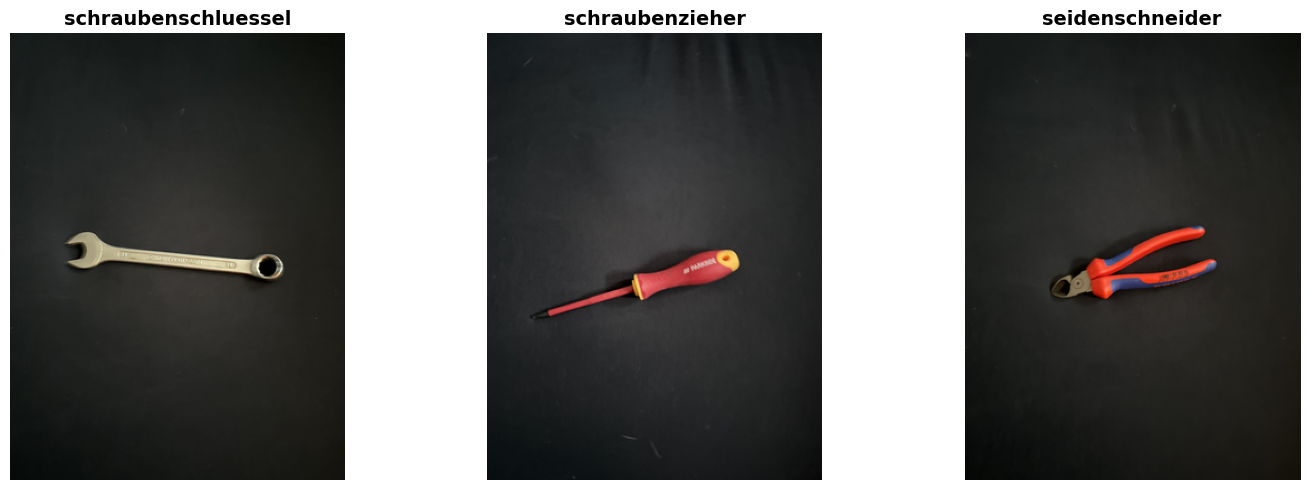

In [ ]:
# Importiere die Funktion aus dem Skript
from scripts.schritt1_aufloesungsreduktion import resize_image

# Verwende die Funktion

im1_resized = resize_image(im1, pr)
im2_resized = resize_image(im2, pr)
im3_resized = resize_image(im3, pr)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(im1_resized)
axes[0].set_title(klasse1, fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(im2_resized)
axes[1].set_title(klasse2, fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(im3_resized)
axes[2].set_title(klasse3, fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Die Auflösung sollte nun Ihren Wünschen entsprechen (`NrRows`, `NrCols`, Anzahl Farbkanäle):

In [ ]:
np_im = np.array(im1_resized)
print(klasse1)
print("Shape:", np_im.shape)
print("Size:", im1_resized.size)
print("Mode:", im1_resized.mode)
print("----------------------------")
print(klasse2)
print("Shape:", np_im.shape)
print("Size:", im2_resized.size)
print("Mode:", im2_resized.mode)
print("----------------------------")
print(klasse3)
print("Shape:", np_im.shape)
print("Size:", im3_resized.size)
print("Mode:", im3_resized.mode)
print("----------------------------")

schraubenschluessel
Shape: (400, 300, 3)
Size: (300, 400)
Mode: RGB
----------------------------
schraubenzieher
Shape: (400, 300, 3)
Size: (300, 400)
Mode: RGB
----------------------------
seidenschneider
Shape: (400, 300, 3)
Size: (300, 400)
Mode: RGB
----------------------------


## Schritt 2: Ränder abschneiden
Als nächstes müssen ev. die Ränder des Bildes überdeckt werden. Damit können Artefakte beseitigt werden, z.B. wenn der schwarze Hintergrund nicht bis an den Rand des Bildes reicht. `fraction_of_rows_to_remove` und `fraction_of_cols_to_remove` geben an, wieviel abgeschnitten wird. Aufgefüllt werden die Pixel mit dem Wert `value_to_fill=0` (in allen Farbkanälen). 
! Dieser Schritt war nicht nötig ich habe alle Bilder ordnungsgemäss aufgenommen.
Ich habe als beispiel ein Bild die ränder abgeschnitten verwende jedoch im_filled nicht 

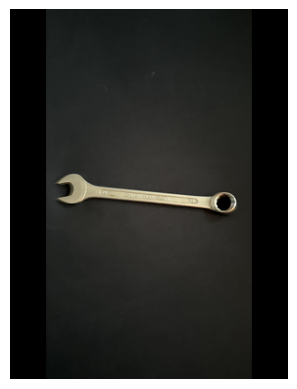

In [ ]:
# Importiere die Funktion aus dem Skript
from scripts.schritt2_raender_abschneiden import fill_borders
im_filled = fill_borders(im1_resized,value_to_fill=fv,fraction_of_rows_to_remove=fr,
                         fraction_of_cols_to_remove=fc)
show_image(im_filled);

### Schritt 3: Hintergrundschwellwert bestimmen
Wählen Sie zunächst sign=+1 für Schwarzen Hintergrund oder sign=-1 für weissen Hintergrund.

Als nächstes soll ein Schwellwert im Farbraum das Objekt vom Hintergrund isolieren. Wir arbeiten im *hsv*-Raum: hue, saturation und value sind die drei Farbdimensionen, für welche jeweils ein Mindestwert (für sign=+1) bzw. Maximalwert (für sign=-1) für Vordergrundpixel festgelegt werden kann. Berechnet wird konkret: `mask = sign*im_hsv[:,:,2]<value_schwellwert*sign` (etc.).

im_filled Shape: (400, 300, 3), dtype: uint8
im_filled Shape: (400, 300, 3), dtype: uint8
im_filled Shape: (400, 300, 3), dtype: uint8


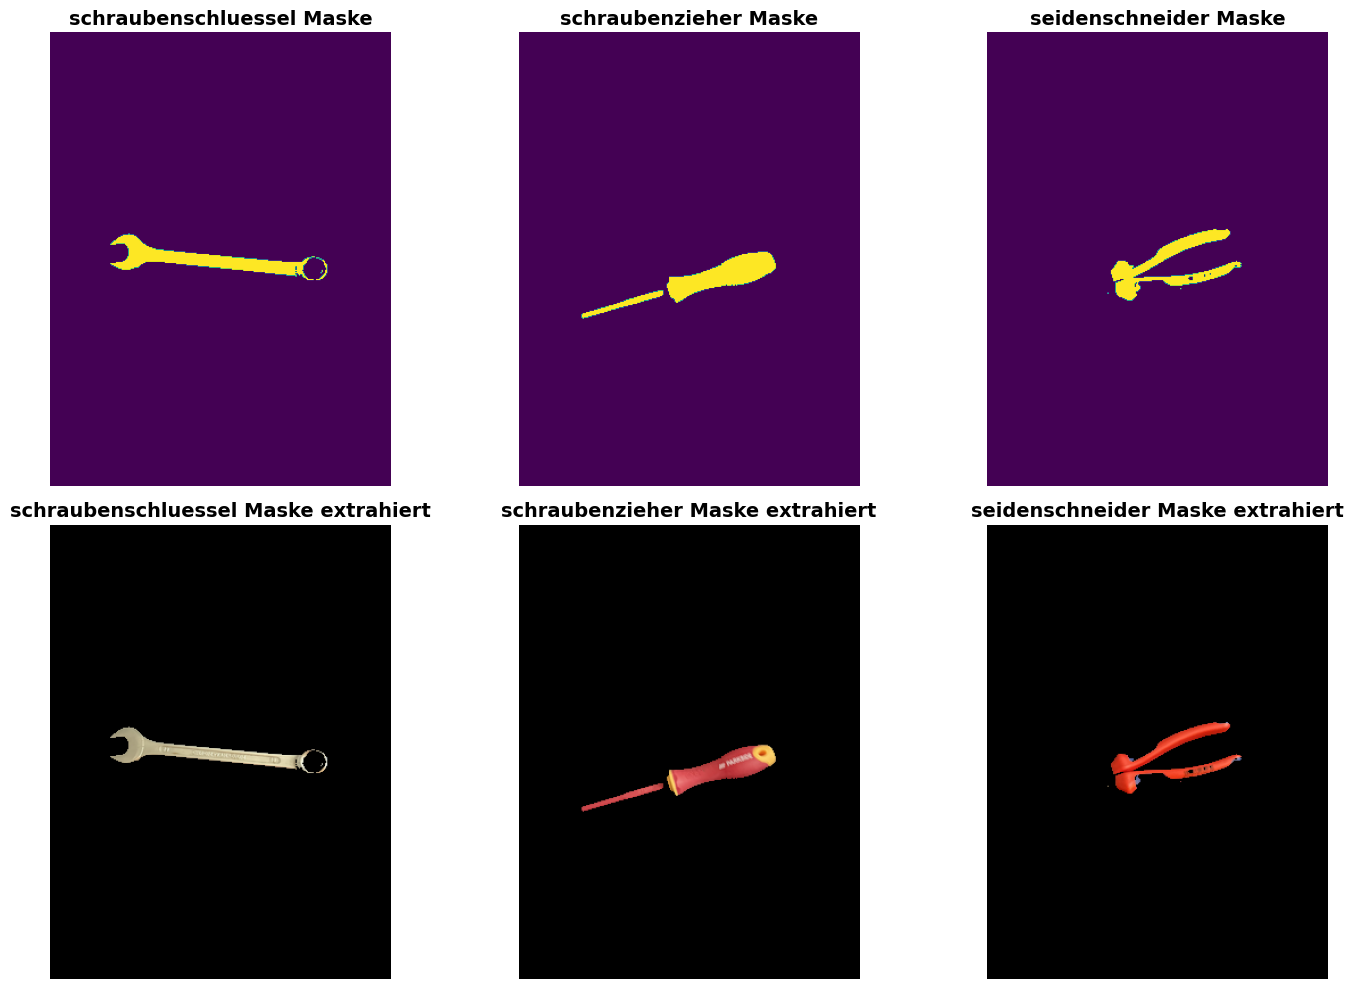

In [ ]:
mask1, masked_image1 = create_mask_from_image(
    im1_resized,
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth
)
# Verwende die importierte Funktion aus dem Skript (aus Zelle 5)
mask2, masked_image2 = create_mask_from_image(
    im2_resized,
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth
)

mask3, masked_image3 = create_mask_from_image(
    im3_resized,
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth
)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Erste Zeile: Masken
axes[0, 0].imshow(mask1)
axes[0, 0].set_title(klasse1 + " Maske", fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask2)
axes[0, 1].set_title(klasse2 + " Maske", fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(mask3)
axes[0, 2].set_title(klasse3 + " Maske", fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Zweite Zeile: Maskierte Bilder
axes[1, 0].imshow(masked_image1)
axes[1, 0].set_title(klasse1 + " Maske extrahiert", fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(masked_image2)
axes[1, 1].set_title(klasse2 + " Maske extrahiert", fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(masked_image3)
axes[1, 2].set_title(klasse3 + " Maske extrahiert", fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Schritt 4: Erosion und Dilatationsfilgergrössen bestimmen

Wenn Hintergrundregionen übrigbleiben, dann ergibt dies zusätzliche Trainingsbilder, welche nicht einer Klasse zugeordnet sind- und es kostet auch viel Rechenzeit. Kleine, isolierte Maskenpixel möchten wir daher als nächstes durch Erosion entfernen.

**Aufgabe 3:** Finden Sie Werte für es und ds, welche möglichst keine vereinzelte Hintergrundpixel in der Maske übrig lassen:

Ev. haben Sie auch Glück, und Sie sehen oben nur eine einzige zusammenhängende gelbe Struktur? Dann können Sie die Werte so lassen, wie sie sind!

`create_mask` ist nun einfach eine Routine, welche die obigen Schritte der Maskenbildung zusammenfasst. Sie sollte das gleiche Bild `morphed_mask` wie oben erstellen:

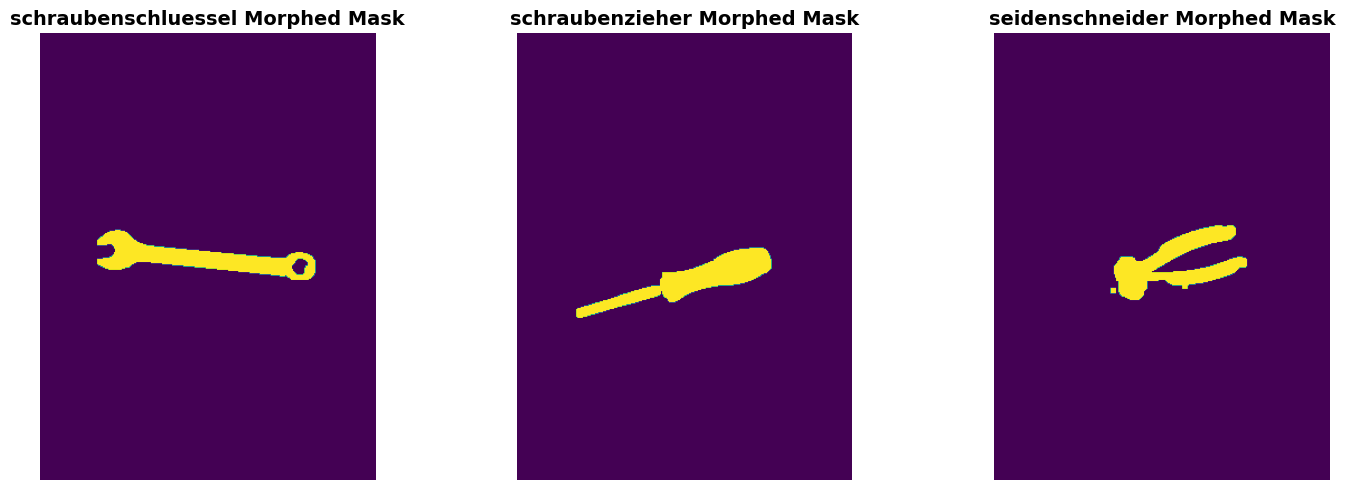

In [ ]:
morphed_mask1 = create_mask(
    np.array(im1_resized), 
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth,
    erosion_size=es,
    dilation_size=ds
)
morphed_mask2 = create_mask(
    np.array(im2_resized), 
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth,
    erosion_size=es,
    dilation_size=ds
)
morphed_mask3 = create_mask(
    np.array(im3_resized), 
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth,
    erosion_size=es,
    dilation_size=ds
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(morphed_mask1)
axes[0].set_title(klasse1 + " Morphed Mask", fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(morphed_mask2)
axes[1].set_title(klasse2 + " Morphed Mask", fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(morphed_mask3)
axes[2].set_title(klasse3 + " Morphed Mask", fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Nun wird die Maske benutzt, um das Objekt (oder die Objekte) aus dem Bild auszuschneiden:
ich gebe den shape gleich mit aus. 

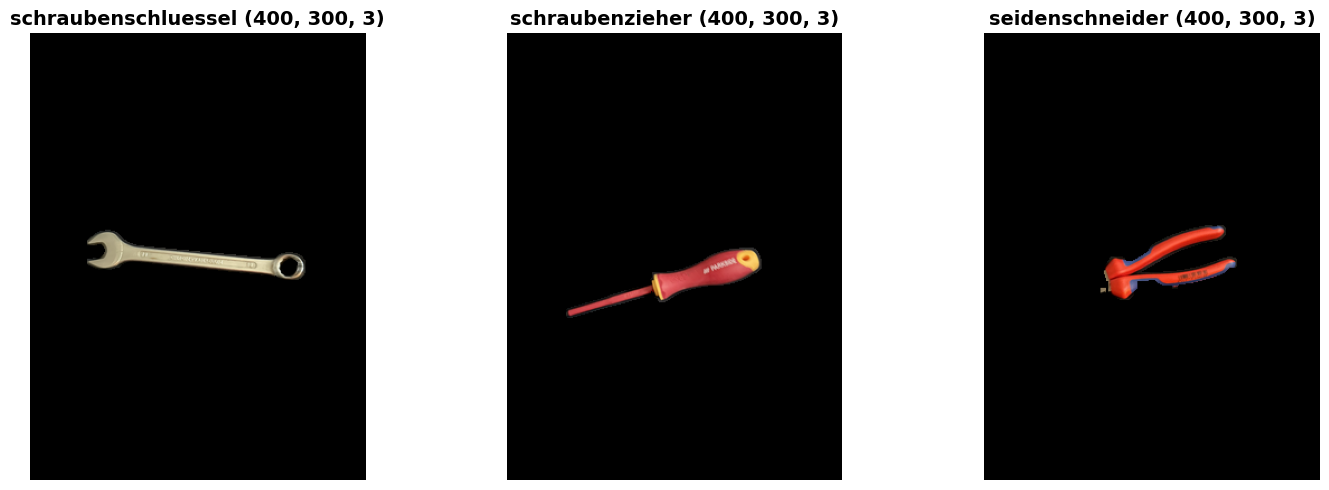

In [ ]:
masked_image1 = create_masked_image(im1_resized, morphed_mask1)
masked_image2 = create_masked_image(im2_resized, morphed_mask2)
masked_image3 = create_masked_image(im3_resized, morphed_mask3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(masked_image1)
axes[0].set_title(klasse1 + " " + str(masked_image1.shape), fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(masked_image2)
axes[1].set_title(klasse2 + " " + str(masked_image2.shape), fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(masked_image3)
axes[2].set_title(klasse3 + " " + str(masked_image3.shape), fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Hier sollte ein Bild zu sehen sein, welches einen komplett schwarzen Hintergrund hat, und nur die relevanten Objekte zeigt. Als nächstes hätten wir gerne von jedem Objekt ein separates Bild, so dass wir darauf unseren Bildklassifikator trainieren können.

## Schritt 5: Objekte ausschneiden
Wir haben den Hintergrund eliminiert. Damit ist es nun leichter, die Objekte voneinander zu trennen. Eine Funktion von [scikit-image](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label) tut dies:

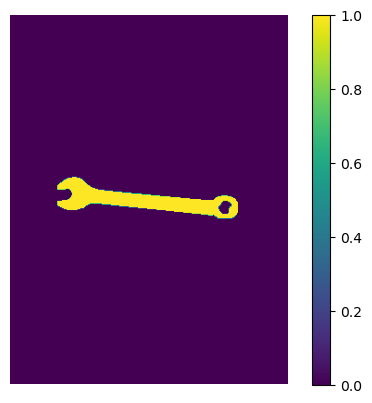

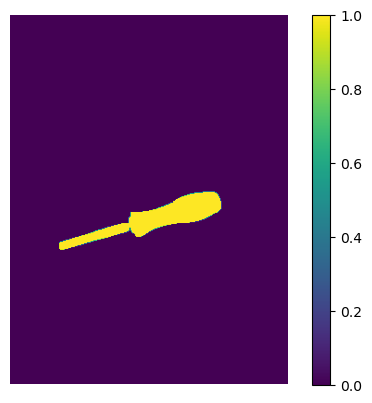

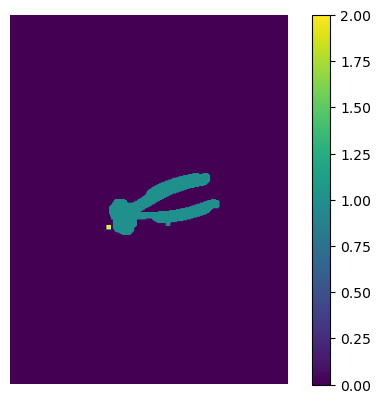

In [ ]:
from skimage.measure import label
label_img1 = label(morphed_mask1)
label_img2 = label(morphed_mask2)
label_img3 = label(morphed_mask3)
show_image(label_img1, show_colorbar=True)
show_image(label_img2, show_colorbar=True)
show_image(label_img3, show_colorbar=True)


Falls das obige Bild wie eine Maske aussieht: Vermutlich liegt nur ein Bild vor- deren Pixel wird dann mit dem Wert "1" aufgefüllt. Wäre ein zweites Objekt vorhanden, würde dieses mit dem Wert "2" aufgefüllt und wäre in einer leicht anderen Farbe sichtbar. Aus diesem gelabelten Bild werden nun Teilbilder extrahiert, welche jeweils nur ein Objekt enthalten:

In [ ]:
label_img1.shape,masked_image1.shape

((400, 300), (400, 300, 3))

In [ ]:
regionlist1,regions1 = extract_regions(label_img1,masked_image1,fraction_of_rows_to_remove=fr)
print(klasse1 + " Regionen " + str(len(regionlist1)))
regionlist2,regions2 = extract_regions(label_img2,masked_image2,fraction_of_rows_to_remove=fr)
print(klasse2 + " Regionen " + str(len(regionlist2)))
regionlist3,regions3 = extract_regions(label_img3,masked_image3,fraction_of_rows_to_remove=fr)
print(klasse3 + " Regionen " + str(len(regionlist3)))

schraubenschluessel Regionen 1
schraubenzieher Regionen 1
seidenschneider Regionen 2


## Schritt 6: Kleine Objekte (Artefakte) ignorieren
Manchmal sind einige der gefundenen Regionen viel zu klein, um echte Objekte zu sein. Es gibt eine Option `--minimum-number-of-pixels` bzw. `-mpx`, welche Regionen unterdrückt, welche zu klein sind. Die Grösse der Regionen wird hier ausgegeben, um diesen Parameter gut einstellen zu können.

Region 0:   3448


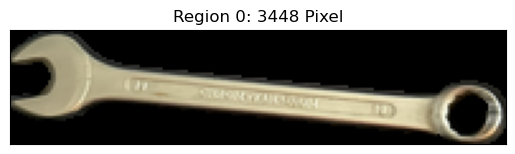

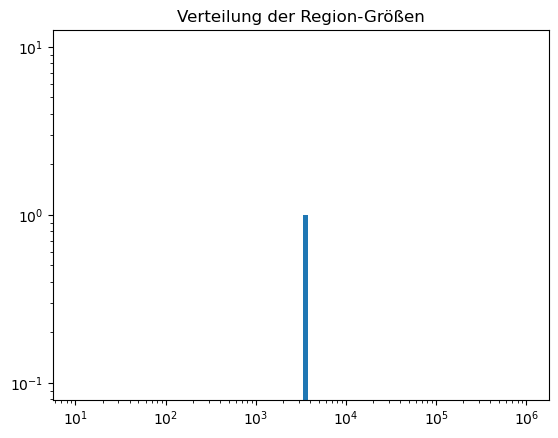

Region 0:   3282


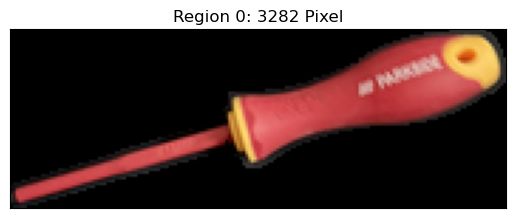

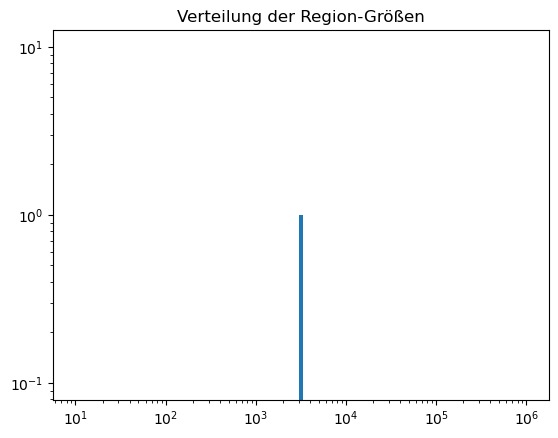

Region 0:   3285
Region 1:     25


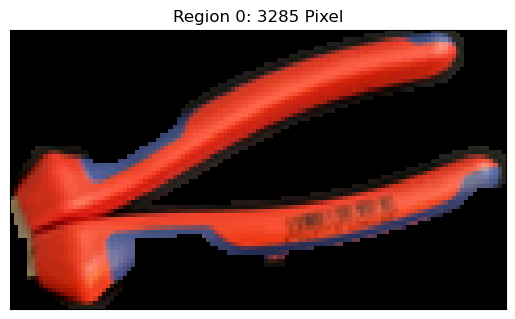

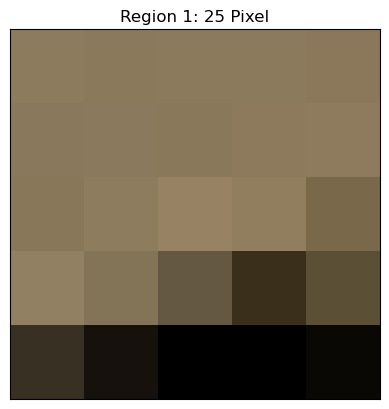

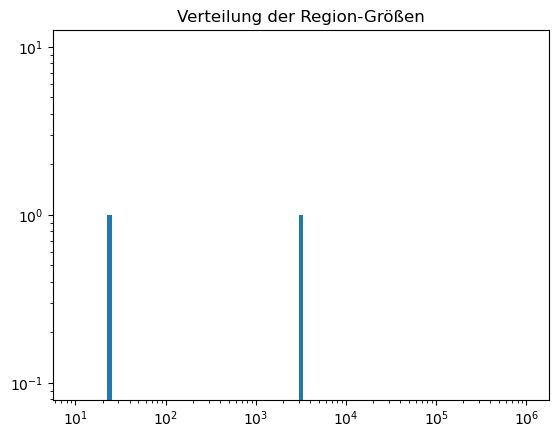

In [ ]:

visualize_regions(regions1)
visualize_regions(regions2)
visualize_regions(regions3)

Schauen wir uns die extrahierten Regionen an - es sollten nicht zu viele sein.

**Aufgabe 4:** Bestimmen Sie einen geeigneten Wert von `mpx`, so dass nur relevante Regionen übrig bleiben. Tragen Sie den Wert in die Parameterliste ein.

Der `mpx`-Wert wird in der nächsten Zelle verwendet:

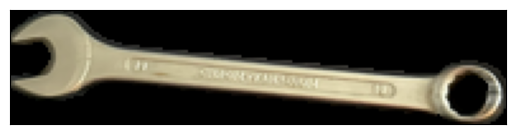

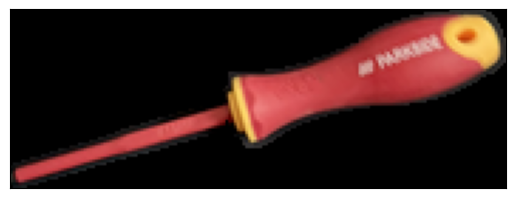

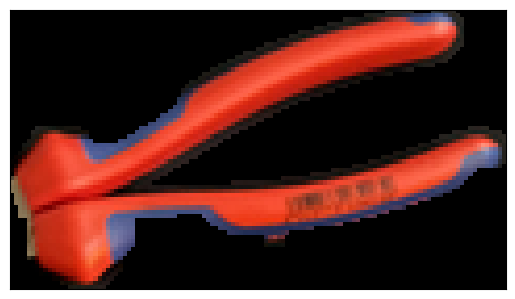

In [ ]:
relevante_regionen1 = show_relevant_regions(regions1)
relevante_regionen2 = show_relevant_regions(regions2)
relevante_regionen3 = show_relevant_regions(regions3)

Sehen Sie hier Ihre extrahierten Objekte, und keine (oder nur wenige) Artefakte?  
Ja?  
Wirklich?  
**Cool!**  
Dann können wir nun versuchen, alle weiteren Daten zu verarbeiten. Das kann  in der Kommandozeile wie folgt erreicht werden:

In [ ]:
Ausgabepfad = Path('/erstellt/object_extraction_output')
Ausgabepfad.mkdir(parents=True, exist_ok=True)
Ausgabepfad

WindowsPath('/erstellt/object_extraction_output')

In [ ]:
from pathlib import Path

dataset_paths = {
    "schraubenzieher": Path("data/schraubenzieher"),
    "schraubenschluessel": Path("data/schraubenschluessel"),
    "seidenschneider": Path("data/seidenschneider"),
}

# Verwende einen lokalen Pfad statt des Kaggle-Pfads
output_path = Path("extracted")  # Relativer Pfad zum aktuellen Verzeichnis
output_path.mkdir(parents=True, exist_ok=True)
print(f"Extrahierte Bilder werden gespeichert in: {output_path.absolute()}")

for class_name, class_path in dataset_paths.items():
    print(f"\nExtrahiere Klasse: {class_name}")
    print("Pfad:", class_path)

    if not class_path.exists():
        print("  WARNUNG: Pfad existiert nicht – ueberspringe.")
        continue

    target_dir = output_path / class_name
    target_dir.mkdir(parents=True, exist_ok=True)

    # Suche nach verschiedenen Bildformaten (JPEG, jpg, jpeg, JPG, etc.)
    # Unterstützt sowohl Groß- als auch Kleinschreibung
    image_extensions = ["*.JPEG", "*.jpeg", "*.JPG", "*.jpg", "*.png", "*.PNG"]
    image_files = []
    for ext in image_extensions:
        image_files.extend(class_path.rglob(ext))
    
    # Entferne Duplikate (falls Dateien mit verschiedenen Groß-/Kleinschreibungen existieren)
    image_files = list(set(image_files))

    print(f"  {len(image_files)} Bilder gefunden")

    # Setze hue_threshold und saturation_threshold auf None, falls nicht definiert
    hue_thresh = hue_threshold if 'hue_threshold' in globals() else None
    sat_thresh = saturation_threshold if 'saturation_threshold' in globals() else None

    for file_path in image_files:
        process_file(
            file_path,
            fraction_of_rows_to_remove=fr,
            fraction_of_cols_to_remove=fc,
            hue_threshold=hue_thresh,
            saturation_threshold=None,
            value_threshold=vth,
            erosion_size=es,
            dilation_size=ds,
            min_num_pixels=mpx,
            preprocessing_resolution=pr,
            value_to_fill=fv,
            outputpath=str(target_dir),
        )

print("\nFertig! Extrahierte Bilder liegen unter:")
print(output_path)


INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Extrahierte Bilder werden gespeichert in: d:\dev\git\privat\Studium\dsci-semesterarebeit\extracted

Extrahiere Klasse: schraubenzieher
Pfad: data\schraubenzieher
  117 Bilder gefunden


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(54, 188, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3535 Pixel
Behalte nur das größte Objekt: 3535 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(90, 176, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3723 Pixel
Behalte nur das größte Objekt: 3723 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(78, 188, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2428 Pixel
Behalte nur das größte Objekt: 2428 Pixel
Verbinde 2 große Objekte (jeweils >= 485 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(43, 215, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3243 Pixel
Behalte nur das größte Objekt: 3243 Pixel
Verbinde 2 große Objekte (jeweils >= 648 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(135, 194, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3452 Pixel
Behalte nur das größte Objekt: 3452 Pixel
Verbinde 2 große Objekte (jeweils >= 690 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(164, 121, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2640 Pixel
Behalte nur das größte Objekt: 2640 Pixel
Verbinde 2 große Objekte (jeweils >= 528 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(55, 218, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3048 Pixel
Behalte nur das größte Objekt: 3048 Pixel
Verbinde 2 große Objekte (jeweils >= 609 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(180, 115, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2625 Pixel
Behalte nur das größte Objekt: 2625 Pixel
Verbinde 2 große Objekte (jeweils >= 525 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(138, 173, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2834 Pixel
Behalte nur das größte Objekt: 2834 Pixel
Verbinde 2 große Objekte (jeweils >= 566 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(190, 101, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2620 Pixel
Behalte nur das größte Objekt: 2620 Pixel
Verbinde 2 große Objekte (jeweils >= 524 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(109, 203, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3414 Pixel
Behalte nur das größte Objekt: 3414 Pixel
Verbinde 2 große Objekte (jeweils >= 682 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(116, 171, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3893 Pixel
Behalte nur das größte Objekt: 3893 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(202, 47, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2528 Pixel
Behalte nur das größte Objekt: 2528 Pixel
Verbinde 2 große Objekte (jeweils >= 505 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(114, 141, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3470 Pixel
Behalte nur das größte Objekt: 3470 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(58, 114, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2957 Pixel
Behalte nur das größte Objekt: 2957 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(212, 127, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3529 Pixel
Behalte nur das größte Objekt: 3529 Pixel
Verbinde 2 große Objekte (jeweils >= 705 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(173, 174, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3521 Pixel
Behalte nur das größte Objekt: 3521 Pixel
Verbinde 2 große Objekte (jeweils >= 704 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(88, 213, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3394 Pixel
Behalte nur das größte Objekt: 3394 Pixel
Verbinde 2 große Objekte (jeweils >= 678 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(72, 210, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3707 Pixel
Behalte nur das größte Objekt: 3707 Pixel
Verbinde 2 große Objekte (jeweils >= 741 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(148, 165, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2661 Pixel
Behalte nur das größte Objekt: 2661 Pixel
Verbinde 2 große Objekte (jeweils >= 532 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(153, 45, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 4729 Pixel
Behalte nur das größte Objekt: 4729 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(43, 220, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3358 Pixel
Behalte nur das größte Objekt: 3358 Pixel
Verbinde 2 große Objekte (jeweils >= 671 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(48, 220, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3430 Pixel
Behalte nur das größte Objekt: 3430 Pixel
Verbinde 2 große Objekte (jeweils >= 686 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(59, 199, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3962 Pixel
Behalte nur das größte Objekt: 3962 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(220, 82, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3063 Pixel
Behalte nur das größte Objekt: 3063 Pixel
Verbinde 2 große Objekte (jeweils >= 612 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(85, 94, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2801 Pixel
Behalte nur das größte Objekt: 2801 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(224, 78, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3238 Pixel
Behalte nur das größte Objekt: 3238 Pixel
Verbinde 2 große Objekte (jeweils >= 647 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(47, 222, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3232 Pixel
Behalte nur das größte Objekt: 3232 Pixel
Verbinde 2 große Objekte (jeweils >= 646 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(139, 97, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3527 Pixel
Behalte nur das größte Objekt: 3527 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(159, 145, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2524 Pixel
Behalte nur das größte Objekt: 2524 Pixel
Verbinde 2 große Objekte (jeweils >= 504 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(41, 192, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2357 Pixel
Behalte nur das größte Objekt: 2357 Pixel
Verbinde 2 große Objekte (jeweils >= 471 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(33, 196, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3596 Pixel
Behalte nur das größte Objekt: 3596 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(89, 183, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3668 Pixel
Behalte nur das größte Objekt: 3668 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(101, 222, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3756 Pixel
Behalte nur das größte Objekt: 3756 Pixel
Verbinde 2 große Objekte (jeweils >= 751 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(63, 209, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2830 Pixel
Behalte nur das größte Objekt: 2830 Pixel
Verbinde 2 große Objekte (jeweils >= 566 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(60, 212, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2910 Pixel
Behalte nur das größte Objekt: 2910 Pixel
Verbinde 2 große Objekte (jeweils >= 582 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(74, 198, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4062 Pixel
Behalte nur das größte Objekt: 4062 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(62, 175, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3244 Pixel
Behalte nur das größte Objekt: 3244 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(51, 221, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3420 Pixel
Behalte nur das größte Objekt: 3420 Pixel
Verbinde 2 große Objekte (jeweils >= 684 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(114, 191, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2749 Pixel
Behalte nur das größte Objekt: 2749 Pixel
Verbinde 2 große Objekte (jeweils >= 549 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(122, 180, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2786 Pixel
Behalte nur das größte Objekt: 2786 Pixel
Verbinde 2 große Objekte (jeweils >= 557 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(199, 82, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2698 Pixel
Behalte nur das größte Objekt: 2698 Pixel
Verbinde 2 große Objekte (jeweils >= 539 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(216, 88, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2985 Pixel
Behalte nur das größte Objekt: 2985 Pixel
Verbinde 2 große Objekte (jeweils >= 597 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(56, 184, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3363 Pixel
Behalte nur das größte Objekt: 3363 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(147, 65, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 4386 Pixel
Behalte nur das größte Objekt: 4386 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(84, 192, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3677 Pixel
Behalte nur das größte Objekt: 3677 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(148, 169, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2733 Pixel
Behalte nur das größte Objekt: 2733 Pixel
Verbinde 2 große Objekte (jeweils >= 546 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(155, 50, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 4808 Pixel
Behalte nur das größte Objekt: 4808 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(149, 108, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3135 Pixel
Behalte nur das größte Objekt: 3135 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(188, 159, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3585 Pixel
Behalte nur das größte Objekt: 3585 Pixel
Verbinde 2 große Objekte (jeweils >= 717 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(33, 190, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3342 Pixel
Behalte nur das größte Objekt: 3342 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(59, 205, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3079 Pixel
Behalte nur das größte Objekt: 3079 Pixel
Verbinde 2 große Objekte (jeweils >= 615 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(106, 200, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 4902 Pixel
Behalte nur das größte Objekt: 4902 Pixel
Verbinde 2 große Objekte (jeweils >= 980 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(49, 220, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3274 Pixel
Behalte nur das größte Objekt: 3274 Pixel
Verbinde 2 große Objekte (jeweils >= 654 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(165, 90, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3226 Pixel
Behalte nur das größte Objekt: 3226 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(101, 74, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 2890 Pixel
Behalte nur das größte Objekt: 2890 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(197, 150, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3584 Pixel
Behalte nur das größte Objekt: 3584 Pixel
Verbinde 2 große Objekte (jeweils >= 716 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(210, 42, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2684 Pixel
Behalte nur das größte Objekt: 2684 Pixel
Verbinde 2 große Objekte (jeweils >= 536 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(36, 196, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3622 Pixel
Behalte nur das größte Objekt: 3622 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(122, 195, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2889 Pixel
Behalte nur das größte Objekt: 2889 Pixel
Verbinde 2 große Objekte (jeweils >= 577 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(44, 209, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3084 Pixel
Behalte nur das größte Objekt: 3084 Pixel
Verbinde 2 große Objekte (jeweils >= 616 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(104, 155, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3304 Pixel
Behalte nur das größte Objekt: 3304 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(64, 187, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3527 Pixel
Behalte nur das größte Objekt: 3527 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(207, 48, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2758 Pixel
Behalte nur das größte Objekt: 2758 Pixel
Verbinde 2 große Objekte (jeweils >= 551 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(195, 177, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3739 Pixel
Behalte nur das größte Objekt: 3739 Pixel
Verbinde 2 große Objekte (jeweils >= 747 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(94, 185, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2463 Pixel
Behalte nur das größte Objekt: 2463 Pixel
Verbinde 2 große Objekte (jeweils >= 492 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(65, 211, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2838 Pixel
Behalte nur das größte Objekt: 2838 Pixel
Verbinde 2 große Objekte (jeweils >= 567 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(204, 63, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2684 Pixel
Behalte nur das größte Objekt: 2684 Pixel
Verbinde 2 große Objekte (jeweils >= 536 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(127, 131, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3206 Pixel
Behalte nur das größte Objekt: 3206 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(151, 156, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2572 Pixel
Behalte nur das größte Objekt: 2572 Pixel
Verbinde 2 große Objekte (jeweils >= 514 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(57, 189, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2943 Pixel
Behalte nur das größte Objekt: 2943 Pixel
Verbinde 2 große Objekte (jeweils >= 588 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(192, 115, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2844 Pixel
Behalte nur das größte Objekt: 2844 Pixel
Verbinde 2 große Objekte (jeweils >= 568 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(100, 180, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3617 Pixel
Behalte nur das größte Objekt: 3617 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(128, 67, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3463 Pixel
Behalte nur das größte Objekt: 3463 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(117, 173, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2462 Pixel
Behalte nur das größte Objekt: 2462 Pixel
Verbinde 2 große Objekte (jeweils >= 492 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(203, 71, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2707 Pixel
Behalte nur das größte Objekt: 2707 Pixel
Verbinde 2 große Objekte (jeweils >= 541 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(78, 222, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3626 Pixel
Behalte nur das größte Objekt: 3626 Pixel
Verbinde 2 große Objekte (jeweils >= 725 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(38, 188, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3417 Pixel
Behalte nur das größte Objekt: 3417 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(155, 103, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3166 Pixel
Behalte nur das größte Objekt: 3166 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(97, 166, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3326 Pixel
Behalte nur das größte Objekt: 3326 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(174, 133, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2716 Pixel
Behalte nur das größte Objekt: 2716 Pixel
Verbinde 2 große Objekte (jeweils >= 543 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(207, 97, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2837 Pixel
Behalte nur das größte Objekt: 2837 Pixel
Verbinde 2 große Objekte (jeweils >= 567 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(199, 95, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2593 Pixel
Behalte nur das größte Objekt: 2593 Pixel
Verbinde 2 große Objekte (jeweils >= 518 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(165, 92, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3235 Pixel
Behalte nur das größte Objekt: 3235 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(135, 122, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3089 Pixel
Behalte nur das größte Objekt: 3089 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(55, 221, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3490 Pixel
Behalte nur das größte Objekt: 3490 Pixel
Verbinde 2 große Objekte (jeweils >= 698 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(131, 204, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 6208 Pixel
Behalte nur das größte Objekt: 6208 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(144, 192, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3467 Pixel
Behalte nur das größte Objekt: 3467 Pixel
Verbinde 2 große Objekte (jeweils >= 693 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(126, 142, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3325 Pixel
Behalte nur das größte Objekt: 3325 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(164, 135, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2429 Pixel
Behalte nur das größte Objekt: 2429 Pixel
Verbinde 2 große Objekte (jeweils >= 485 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(143, 113, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3027 Pixel
Behalte nur das größte Objekt: 3027 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(199, 60, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2560 Pixel
Behalte nur das größte Objekt: 2560 Pixel
Verbinde 2 große Objekte (jeweils >= 512 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(76, 177, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3306 Pixel
Behalte nur das größte Objekt: 3306 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(63, 213, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2981 Pixel
Behalte nur das größte Objekt: 2981 Pixel
Verbinde 2 große Objekte (jeweils >= 596 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(141, 209, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3742 Pixel
Behalte nur das größte Objekt: 3742 Pixel
Verbinde 2 große Objekte (jeweils >= 748 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(65, 222, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3483 Pixel
Behalte nur das größte Objekt: 3483 Pixel
Verbinde 2 große Objekte (jeweils >= 696 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(161, 183, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3506 Pixel
Behalte nur das größte Objekt: 3506 Pixel
Verbinde 2 große Objekte (jeweils >= 701 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(72, 182, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3558 Pixel
Behalte nur das größte Objekt: 3558 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(167, 141, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2715 Pixel
Behalte nur das größte Objekt: 2715 Pixel
Verbinde 2 große Objekte (jeweils >= 543 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(60, 210, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2893 Pixel
Behalte nur das größte Objekt: 2893 Pixel
Verbinde 2 große Objekte (jeweils >= 578 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(38, 191, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2343 Pixel
Behalte nur das größte Objekt: 2343 Pixel
Verbinde 2 große Objekte (jeweils >= 468 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(146, 174, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2791 Pixel
Behalte nur das größte Objekt: 2791 Pixel
Verbinde 2 große Objekte (jeweils >= 558 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(124, 172, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2433 Pixel
Behalte nur das größte Objekt: 2433 Pixel
Verbinde 2 große Objekte (jeweils >= 486 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(103, 183, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4034 Pixel
Behalte nur das größte Objekt: 4034 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(46, 193, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2408 Pixel
Behalte nur das größte Objekt: 2408 Pixel
Verbinde 2 große Objekte (jeweils >= 481 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(154, 101, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3091 Pixel
Behalte nur das größte Objekt: 3091 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(107, 175, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3859 Pixel
Behalte nur das größte Objekt: 3859 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(150, 46, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 4582 Pixel
Behalte nur das größte Objekt: 4582 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(209, 46, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2728 Pixel
Behalte nur das größte Objekt: 2728 Pixel
Verbinde 2 große Objekte (jeweils >= 545 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(62, 109, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2839 Pixel
Behalte nur das größte Objekt: 2839 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(167, 193, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3911 Pixel
Behalte nur das größte Objekt: 3911 Pixel
Verbinde 2 große Objekte (jeweils >= 782 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(64, 200, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3999 Pixel
Behalte nur das größte Objekt: 3999 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(128, 109, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3558 Pixel
Behalte nur das größte Objekt: 3558 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(52, 222, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3144 Pixel
Behalte nur das größte Objekt: 3144 Pixel
Verbinde 2 große Objekte (jeweils >= 628 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(144, 88, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3827 Pixel
Behalte nur das größte Objekt: 3827 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(114, 193, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2733 Pixel
Behalte nur das größte Objekt: 2733 Pixel
Verbinde 2 große Objekte (jeweils >= 546 Pixel)
Nach Verbindung: 1 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(161, 148, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2629 Pixel
Behalte nur das größte Objekt: 2629 Pixel
Verbinde 2 große Objekte (jeweils >= 525 Pixel)
Nach Verbindung: 1 Objekt(e)

Extrahiere Klasse: schraubenschluessel
Pfad: data\schraubenschluessel
  82 Bilder gefunden


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(189, 102, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3991 Pixel
Behalte nur das größte Objekt: 3991 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(202, 60, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3891 Pixel
Behalte nur das größte Objekt: 3891 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(187, 78, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3733 Pixel
Behalte nur das größte Objekt: 3733 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(103, 142, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2787 Pixel
Behalte nur das größte Objekt: 2787 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(154, 145, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3780 Pixel
Behalte nur das größte Objekt: 3780 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(172, 85, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3504 Pixel
Behalte nur das größte Objekt: 3504 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(74, 173, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3190 Pixel
Behalte nur das größte Objekt: 3190 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(169, 97, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3249 Pixel
Behalte nur das größte Objekt: 3249 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(37, 177, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 3 Regionen
Größte Region: 3108 Pixel
Behalte nur das größte Objekt: 3108 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(64, 185, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3308 Pixel
Behalte nur das größte Objekt: 3308 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(47, 169, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2849 Pixel
Behalte nur das größte Objekt: 2849 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(41, 195, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3315 Pixel
Behalte nur das größte Objekt: 3315 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(105, 156, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3159 Pixel
Behalte nur das größte Objekt: 3159 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(174, 116, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3799 Pixel
Behalte nur das größte Objekt: 3799 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(103, 171, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3428 Pixel
Behalte nur das größte Objekt: 3428 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(141, 158, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3666 Pixel
Behalte nur das größte Objekt: 3666 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(197, 52, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3735 Pixel
Behalte nur das größte Objekt: 3735 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(185, 117, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4028 Pixel
Behalte nur das größte Objekt: 4028 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(180, 37, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3340 Pixel
Behalte nur das größte Objekt: 3340 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(39, 167, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2790 Pixel
Behalte nur das größte Objekt: 2790 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(46, 195, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3365 Pixel
Behalte nur das größte Objekt: 3365 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(203, 106, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4286 Pixel
Behalte nur das größte Objekt: 4286 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(127, 150, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3258 Pixel
Behalte nur das größte Objekt: 3258 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(141, 124, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2964 Pixel
Behalte nur das größte Objekt: 2964 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(46, 194, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3359 Pixel
Behalte nur das größte Objekt: 3359 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(176, 110, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3825 Pixel
Behalte nur das größte Objekt: 3825 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(36, 195, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3335 Pixel
Behalte nur das größte Objekt: 3335 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(167, 95, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3205 Pixel
Behalte nur das größte Objekt: 3205 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(36, 185, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3243 Pixel
Behalte nur das größte Objekt: 3243 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(192, 50, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3417 Pixel
Behalte nur das größte Objekt: 3417 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(150, 142, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3669 Pixel
Behalte nur das größte Objekt: 3669 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(117, 165, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3489 Pixel
Behalte nur das größte Objekt: 3489 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(171, 130, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3884 Pixel
Behalte nur das größte Objekt: 3884 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(195, 70, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3848 Pixel
Behalte nur das größte Objekt: 3848 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(190, 122, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4106 Pixel
Behalte nur das größte Objekt: 4106 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(138, 150, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3671 Pixel
Behalte nur das größte Objekt: 3671 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(110, 148, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3196 Pixel
Behalte nur das größte Objekt: 3196 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(35, 180, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3087 Pixel
Behalte nur das größte Objekt: 3087 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(95, 177, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3392 Pixel
Behalte nur das größte Objekt: 3392 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(191, 99, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3944 Pixel
Behalte nur das größte Objekt: 3944 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(207, 46, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3979 Pixel
Behalte nur das größte Objekt: 3979 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(152, 142, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3920 Pixel
Behalte nur das größte Objekt: 3920 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(200, 61, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4035 Pixel
Behalte nur das größte Objekt: 4035 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(36, 176, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 3 Regionen
Größte Region: 3015 Pixel
Behalte nur das größte Objekt: 3015 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(193, 82, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3936 Pixel
Behalte nur das größte Objekt: 3936 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(194, 49, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3699 Pixel
Behalte nur das größte Objekt: 3699 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(198, 124, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4468 Pixel
Behalte nur das größte Objekt: 4468 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(162, 132, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3763 Pixel
Behalte nur das größte Objekt: 3763 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(172, 72, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3080 Pixel
Behalte nur das größte Objekt: 3080 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(154, 108, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3326 Pixel
Behalte nur das größte Objekt: 3326 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(44, 195, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3400 Pixel
Behalte nur das größte Objekt: 3400 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(180, 72, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3362 Pixel
Behalte nur das größte Objekt: 3362 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(161, 133, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3957 Pixel
Behalte nur das größte Objekt: 3957 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(196, 39, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3731 Pixel
Behalte nur das größte Objekt: 3731 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(33, 178, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3118 Pixel
Behalte nur das größte Objekt: 3118 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(94, 162, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3198 Pixel
Behalte nur das größte Objekt: 3198 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(67, 173, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3223 Pixel
Behalte nur das größte Objekt: 3223 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(206, 45, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3936 Pixel
Behalte nur das größte Objekt: 3936 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(156, 132, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3537 Pixel
Behalte nur das größte Objekt: 3537 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(199, 72, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3758 Pixel
Behalte nur das größte Objekt: 3758 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(174, 55, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2979 Pixel
Behalte nur das größte Objekt: 2979 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(104, 174, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3488 Pixel
Behalte nur das größte Objekt: 3488 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(191, 92, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3884 Pixel
Behalte nur das größte Objekt: 3884 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(198, 81, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3790 Pixel
Behalte nur das größte Objekt: 3790 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(150, 147, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3834 Pixel
Behalte nur das größte Objekt: 3834 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(195, 45, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4023 Pixel
Behalte nur das größte Objekt: 4023 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(88, 181, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3428 Pixel
Behalte nur das größte Objekt: 3428 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(199, 85, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3832 Pixel
Behalte nur das größte Objekt: 3832 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(196, 40, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3973 Pixel
Behalte nur das größte Objekt: 3973 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(180, 49, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3284 Pixel
Behalte nur das größte Objekt: 3284 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(196, 65, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3871 Pixel
Behalte nur das größte Objekt: 3871 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(115, 166, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3464 Pixel
Behalte nur das größte Objekt: 3464 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(42, 196, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3293 Pixel
Behalte nur das größte Objekt: 3293 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(198, 84, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3795 Pixel
Behalte nur das größte Objekt: 3795 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(195, 75, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3918 Pixel
Behalte nur das größte Objekt: 3918 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(143, 122, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3218 Pixel
Behalte nur das größte Objekt: 3218 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(100, 152, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3060 Pixel
Behalte nur das größte Objekt: 3060 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(75, 177, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3242 Pixel
Behalte nur das größte Objekt: 3242 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(188, 114, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4315 Pixel
Behalte nur das größte Objekt: 4315 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(111, 169, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3470 Pixel
Behalte nur das größte Objekt: 3470 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(203, 55, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3903 Pixel
Behalte nur das größte Objekt: 3903 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(71, 193, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3639 Pixel
Behalte nur das größte Objekt: 3639 Pixel

Extrahiere Klasse: seidenschneider
Pfad: data\seidenschneider
  113 Bilder gefunden


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(130, 84, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3928 Pixel
Behalte nur das größte Objekt: 3928 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(42, 111, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 2981 Pixel
Behalte nur das größte Objekt: 2981 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(159, 105, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 6060 Pixel
Behalte nur das größte Objekt: 6060 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(96, 99, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3442 Pixel
Behalte nur das größte Objekt: 3442 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(91, 135, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4477 Pixel
Behalte nur das größte Objekt: 4477 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(74, 114, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3204 Pixel
Behalte nur das größte Objekt: 3204 Pixel


INFO:object_extraction:Nach Filterung: 2 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(52, 9, 3), (79, 105, 3)]
INFO:object_extraction:skipping region: num_pix=1968,shape:(52, 9, 3),area:1968.0, as num_pix is < 2000
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 4 Regionen
Größte Region: 2553 Pixel
Behalte nur das größte Objekt: 2553 Pixel
Verbinde 2 große Objekte (jeweils >= 510 Pixel)
Nach Verbindung: 2 Objekt(e)


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(105, 84, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 2966 Pixel
Behalte nur das größte Objekt: 2966 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(122, 47, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3222 Pixel
Behalte nur das größte Objekt: 3222 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(97, 87, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 2870 Pixel
Behalte nur das größte Objekt: 2870 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(145, 67, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4014 Pixel
Behalte nur das größte Objekt: 4014 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(67, 119, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3257 Pixel
Behalte nur das größte Objekt: 3257 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(87, 123, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3677 Pixel
Behalte nur das größte Objekt: 3677 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(109, 137, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 5134 Pixel
Behalte nur das größte Objekt: 5134 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(106, 98, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3157 Pixel
Behalte nur das größte Objekt: 3157 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(123, 58, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3249 Pixel
Behalte nur das größte Objekt: 3249 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(118, 59, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3426 Pixel
Behalte nur das größte Objekt: 3426 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(46, 111, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3026 Pixel
Behalte nur das größte Objekt: 3026 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(91, 130, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4109 Pixel
Behalte nur das größte Objekt: 4109 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(147, 97, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 5265 Pixel
Behalte nur das größte Objekt: 5265 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(79, 137, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4228 Pixel
Behalte nur das größte Objekt: 4228 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(128, 53, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3020 Pixel
Behalte nur das größte Objekt: 3020 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(122, 132, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4964 Pixel
Behalte nur das größte Objekt: 4964 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(59, 137, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4886 Pixel
Behalte nur das größte Objekt: 4886 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(74, 138, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4337 Pixel
Behalte nur das größte Objekt: 4337 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(102, 116, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 5330 Pixel
Behalte nur das größte Objekt: 5330 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(73, 140, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4345 Pixel
Behalte nur das größte Objekt: 4345 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(110, 89, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3423 Pixel
Behalte nur das größte Objekt: 3423 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(59, 121, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3302 Pixel
Behalte nur das größte Objekt: 3302 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(96, 98, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3180 Pixel
Behalte nur das größte Objekt: 3180 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(101, 105, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3458 Pixel
Behalte nur das größte Objekt: 3458 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(140, 103, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4326 Pixel
Behalte nur das größte Objekt: 4326 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(109, 104, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3576 Pixel
Behalte nur das größte Objekt: 3576 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(164, 68, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 5089 Pixel
Behalte nur das größte Objekt: 5089 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(84, 126, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 5466 Pixel
Behalte nur das größte Objekt: 5466 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(142, 76, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4016 Pixel
Behalte nur das größte Objekt: 4016 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(73, 117, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3295 Pixel
Behalte nur das größte Objekt: 3295 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(98, 124, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3951 Pixel
Behalte nur das größte Objekt: 3951 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(120, 85, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3498 Pixel
Behalte nur das größte Objekt: 3498 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(66, 147, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4686 Pixel
Behalte nur das größte Objekt: 4686 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(64, 106, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3517 Pixel
Behalte nur das größte Objekt: 3517 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(72, 139, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4403 Pixel
Behalte nur das größte Objekt: 4403 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(110, 120, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4146 Pixel
Behalte nur das größte Objekt: 4146 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(129, 100, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4279 Pixel
Behalte nur das größte Objekt: 4279 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(87, 123, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3812 Pixel
Behalte nur das größte Objekt: 3812 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(163, 62, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 5043 Pixel
Behalte nur das größte Objekt: 5043 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(49, 108, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 2642 Pixel
Behalte nur das größte Objekt: 2642 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(57, 136, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4235 Pixel
Behalte nur das größte Objekt: 4235 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(79, 123, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3707 Pixel
Behalte nur das größte Objekt: 3707 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(89, 150, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 5138 Pixel
Behalte nur das größte Objekt: 5138 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(110, 118, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4094 Pixel
Behalte nur das größte Objekt: 4094 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(99, 126, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4144 Pixel
Behalte nur das größte Objekt: 4144 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(122, 47, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 2861 Pixel
Behalte nur das größte Objekt: 2861 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(114, 98, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3798 Pixel
Behalte nur das größte Objekt: 3798 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(120, 135, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 5037 Pixel
Behalte nur das größte Objekt: 5037 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(99, 85, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 2788 Pixel
Behalte nur das größte Objekt: 2788 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(70, 148, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4868 Pixel
Behalte nur das größte Objekt: 4868 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(69, 136, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4165 Pixel
Behalte nur das größte Objekt: 4165 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(69, 125, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3533 Pixel
Behalte nur das größte Objekt: 3533 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(67, 141, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4395 Pixel
Behalte nur das größte Objekt: 4395 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(88, 111, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3163 Pixel
Behalte nur das größte Objekt: 3163 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(77, 148, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4710 Pixel
Behalte nur das größte Objekt: 4710 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(92, 122, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3940 Pixel
Behalte nur das größte Objekt: 3940 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(139, 83, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3745 Pixel
Behalte nur das größte Objekt: 3745 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(158, 92, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 5035 Pixel
Behalte nur das größte Objekt: 5035 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(91, 123, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4327 Pixel
Behalte nur das größte Objekt: 4327 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(123, 60, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3047 Pixel
Behalte nur das größte Objekt: 3047 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(122, 97, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3820 Pixel
Behalte nur das größte Objekt: 3820 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(120, 50, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 2822 Pixel
Behalte nur das größte Objekt: 2822 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(124, 129, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 4615 Pixel
Behalte nur das größte Objekt: 4615 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(98, 96, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3206 Pixel
Behalte nur das größte Objekt: 3206 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(93, 121, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4096 Pixel
Behalte nur das größte Objekt: 4096 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(114, 75, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3287 Pixel
Behalte nur das größte Objekt: 3287 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(83, 113, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3331 Pixel
Behalte nur das größte Objekt: 3331 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(155, 101, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4772 Pixel
Behalte nur das größte Objekt: 4772 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(71, 138, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4329 Pixel
Behalte nur das größte Objekt: 4329 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(72, 146, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4677 Pixel
Behalte nur das größte Objekt: 4677 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(73, 102, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 2812 Pixel
Behalte nur das größte Objekt: 2812 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(123, 91, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3641 Pixel
Behalte nur das größte Objekt: 3641 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(149, 119, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 5337 Pixel
Behalte nur das größte Objekt: 5337 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(129, 123, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 4633 Pixel
Behalte nur das größte Objekt: 4633 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(104, 59, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 2977 Pixel
Behalte nur das größte Objekt: 2977 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(103, 92, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3172 Pixel
Behalte nur das größte Objekt: 3172 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(113, 84, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3277 Pixel
Behalte nur das größte Objekt: 3277 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(169, 116, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 6782 Pixel
Behalte nur das größte Objekt: 6782 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(116, 68, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3199 Pixel
Behalte nur das größte Objekt: 3199 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(72, 137, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4273 Pixel
Behalte nur das größte Objekt: 4273 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(91, 103, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3029 Pixel
Behalte nur das größte Objekt: 3029 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(84, 136, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4267 Pixel
Behalte nur das größte Objekt: 4267 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(108, 140, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4915 Pixel
Behalte nur das größte Objekt: 4915 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(53, 113, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 2880 Pixel
Behalte nur das größte Objekt: 2880 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(107, 121, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4082 Pixel
Behalte nur das größte Objekt: 4082 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(76, 115, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3228 Pixel
Behalte nur das größte Objekt: 3228 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(51, 129, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3761 Pixel
Behalte nur das größte Objekt: 3761 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(136, 85, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3922 Pixel
Behalte nur das größte Objekt: 3922 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(57, 141, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4392 Pixel
Behalte nur das größte Objekt: 4392 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(144, 96, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 5176 Pixel
Behalte nur das größte Objekt: 5176 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(137, 89, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4208 Pixel
Behalte nur das größte Objekt: 4208 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(82, 139, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4371 Pixel
Behalte nur das größte Objekt: 4371 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(71, 117, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3277 Pixel
Behalte nur das größte Objekt: 3277 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(126, 106, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3923 Pixel
Behalte nur das größte Objekt: 3923 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(122, 55, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3466 Pixel
Behalte nur das größte Objekt: 3466 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(74, 138, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4382 Pixel
Behalte nur das größte Objekt: 4382 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(123, 56, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3314 Pixel
Behalte nur das größte Objekt: 3314 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(75, 123, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3771 Pixel
Behalte nur das größte Objekt: 3771 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(84, 112, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3271 Pixel
Behalte nur das größte Objekt: 3271 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(115, 74, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3272 Pixel
Behalte nur das größte Objekt: 3272 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(90, 107, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3325 Pixel
Behalte nur das größte Objekt: 3325 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(131, 87, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 3961 Pixel
Behalte nur das größte Objekt: 3961 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(142, 67, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4014 Pixel
Behalte nur das größte Objekt: 4014 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(113, 80, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 2 Regionen
Größte Region: 3339 Pixel
Behalte nur das größte Objekt: 3339 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(101, 143, 3)]
INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Ursprünglich: 1 Regionen
Größte Region: 4967 Pixel
Behalte nur das größte Objekt: 4967 Pixel


INFO:object_extraction:Nach Filterung: 1 Objekt(e) behalten
INFO:object_extraction:Shapes of extracted regions: [(53, 139, 3)]


Ursprünglich: 1 Regionen
Größte Region: 4319 Pixel
Behalte nur das größte Objekt: 4319 Pixel

Fertig! Extrahierte Bilder liegen unter:
extracted


#### Train-Test-Split
An dieser Stelle lohnt es sich, kurz innezuhalten: Unsere grandiose Strategie ist es, aus Bildern Objekte zu extrahieren und auf diesen dann ein Modell zu trainieren. Aber wir können nicht alle Daten als Trainingsdaten verwenden, sonst haben wir nichts mehr, um die *Generalisierungsfähigkeit* unseres Modells zu messen!  
Die Realität ist, dass wir nur ungern später nochmals neue Daten aufnehmen wollen. Die Liste in `df` oben ist alles, was uns zur Verfügung steht. Es macht daher Sinn, bereits jetzt einen Teil dieser Daten zurückzulegen und zu *schwören* diese Daten nicht für das Training zu benutzen. Wir brauchen ca. 20% *frische* Daten, an denen wir die Verallgemeinerungsfähigkeit unseres Modells überprüfen können.  
[Scikit-Learn](https://scikit-learn.org) bietet uns [hier](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py) verschiedene Strategien an, wie wir aus unseren Trainingsdaten einen Testdatensatz absondern können. Wir könnten einfach [zufällig splitten](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit). Das ist naiv. Lieber eine [k-fache Kreuzvalidierung](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). Aber was, wenn zufälligerweise eine Klasse nur im Testdatensatz auftaucht, und gar nicht im Trainingsdatensatz?! Also [stratifizieren](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) wir. Ok- und was ist, wenn wir überprüfen wollen, dass wir in Bezug auf eine bestimmte Untergruppierung (z.B. nach Geschlecht, Ethnie,...) gut von einer Gruppe auf eine andere verallgemeinern können müssen? Dann darf eine [Gruppe nur in einem Fold vorkommen](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold). Sie sehen- richtig zu splitten kann herausfordernd sein!  
Hier jedenfalls möchten wir zumindest stratifizieren. Wir nehmen mal [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), um unsere Daten zu splitten.

In [ ]:
import pandas as pd
from pathlib import Path

# Verwende den gleichen output_path wie in Cell 61
# Falls Cell 61 nicht ausgeführt wurde, verwende einen lokalen Pfad
try:
    # Versuche den output_path aus Cell 61 zu verwenden
    base = output_path
except NameError:
    # Falls output_path nicht definiert ist, verwende einen lokalen Pfad
    base = Path("extracted")  # Relativer Pfad zum aktuellen Verzeichnis
    if not base.exists():
        # Versuche auch einen absoluten Pfad
        base = Path(os.getcwd()) / "extracted"

print(f"Suche extrahierte Bilder in: {base}")

if not base.exists():
    print(f"WARNUNG: Der Pfad {base} existiert nicht!")
    print("Bitte führen Sie zuerst Cell 61 aus, um die Bilder zu extrahieren.")
    print("Oder passen Sie den Pfad manuell an.")
    df = pd.DataFrame(columns=["Dateiname", "Basisname", "Klassenlabel"])
else:
    rows = []
    
    for klasse in ["schraubenzieher", "schraubenschluessel", "seidenschneider"]:
        kpfad = base / klasse
        if kpfad.exists():
            for fn in kpfad.glob("*.*"):
                # Überspringe Verzeichnisse
                if fn.is_file():
                    rows.append({
                        "Dateiname": str(fn),           # voller Pfad
                        "Basisname": fn.name,           # z.B. "img_001.jpg"
                        "Klassenlabel": klasse          # z.B. "schraubenzieher"
                    })
        else:
            print(f"WARNUNG: Pfad {kpfad} existiert nicht für Klasse {klasse}")
    
    df = pd.DataFrame(rows)
    print(f"Gefunden: {len(df)} Dateien")
    if len(df) > 0:
        print(df.head())
        print(f"\nAnzahl Zeilen: {len(df)}")
    else:
        print("Keine Dateien gefunden! Bitte führen Sie zuerst Cell 61 aus.")

Suche extrahierte Bilder in: extracted
Gefunden: 312 Dateien
                                   Dateiname        Basisname     Klassenlabel
0  extracted\schraubenzieher\IMG_0_1884.JPEG  IMG_0_1884.JPEG  schraubenzieher
1  extracted\schraubenzieher\IMG_0_1885.JPEG  IMG_0_1885.JPEG  schraubenzieher
2  extracted\schraubenzieher\IMG_0_1886.JPEG  IMG_0_1886.JPEG  schraubenzieher
3  extracted\schraubenzieher\IMG_0_1887.JPEG  IMG_0_1887.JPEG  schraubenzieher
4  extracted\schraubenzieher\IMG_0_1888.JPEG  IMG_0_1888.JPEG  schraubenzieher

Anzahl Zeilen: 312


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["KlassenID"] = le.fit_transform(df["Klassenlabel"])
df.head()

,Dateiname,Basisname,Klassenlabel,KlassenID
0,extracted\schraubenzieher\IMG_0_1884.JPEG,IMG_0_1884.JPEG,schraubenzieher,1
1,extracted\schraubenzieher\IMG_0_1885.JPEG,IMG_0_1885.JPEG,schraubenzieher,1
2,extracted\schraubenzieher\IMG_0_1886.JPEG,IMG_0_1886.JPEG,schraubenzieher,1
3,extracted\schraubenzieher\IMG_0_1887.JPEG,IMG_0_1887.JPEG,schraubenzieher,1
4,extracted\schraubenzieher\IMG_0_1888.JPEG,IMG_0_1888.JPEG,schraubenzieher,1


In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(
    df[['Dateiname','Basisname']],
    df['Klassenlabel'],
    test_size=0.2,
    train_size=0.8,
    stratify=df['Klassenlabel'],
    random_state=42
)

# Output wie im Original-Notebook
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

print("Trainingsdaten")
display(ytrain.value_counts())

print("\nTestdaten")
display(ytest.value_counts())

print('\nKlassenverhältnis:')
display((ytest.value_counts() / ytrain.value_counts()))


(249, 2) (63, 2) (249,) (63,)
Trainingsdaten


Klassenlabel
schraubenzieher        93
seidenschneider        90
schraubenschluessel    66
Name: count, dtype: int64


Testdaten


Klassenlabel
schraubenzieher        24
seidenschneider        23
schraubenschluessel    16
Name: count, dtype: int64


Klassenverhältnis:


Klassenlabel
schraubenzieher        0.258065
seidenschneider        0.255556
schraubenschluessel    0.242424
Name: count, dtype: float64

Die Ausgaben oben zeigen die Anzahl Beispiele pro Klasse in den Training- und Testdaten sowie das Verhältnis pro Klasse. Das Verhältnis sollte für alle Klasse etwa gleich gross sein- dies nennt sich *stratifiziertes Training-Test-Splitten*.

In [ ]:
display(Xtrain.head())
ytrain

,Dateiname,Basisname
50,extracted\schraubenzieher\IMG_0_1937.JPEG,IMG_0_1937.JPEG
116,extracted\schraubenzieher\IMG_0_2007.JPEG,IMG_0_2007.JPEG
243,extracted\seidenschneider\IMG_0_2056.JPEG,IMG_0_2056.JPEG
16,extracted\schraubenzieher\IMG_0_1900.JPEG,IMG_0_1900.JPEG
31,extracted\schraubenzieher\IMG_0_1915.JPEG,IMG_0_1915.JPEG


50         schraubenzieher
116        schraubenzieher
243        seidenschneider
16         schraubenzieher
31         schraubenzieher
              ...         
156    schraubenschluessel
126    schraubenschluessel
258        seidenschneider
278        seidenschneider
159    schraubenschluessel
Name: Klassenlabel, Length: 249, dtype: object

#### Shutil - High-level File Operations
Wir kopieren nun die Daten in Unterordner von `pfad_zu_lcl_colab/2_Baumstruktur/`. Die Unterordner sollen die Klassennamen (Farben) sein.

In [ ]:
import shutil
from pathlib import Path

# Prüfe, ob die DataFrames existieren und Daten enthalten
if 'Xtrain' not in globals() or 'Xtest' not in globals() or 'ytrain' not in globals() or 'ytest' not in globals():
    print("FEHLER: Xtrain, Xtest, ytrain oder ytest sind nicht definiert!")
    print("Bitte führen Sie zuerst die Zellen aus, die den Train-Test-Split durchführen.")
    raise NameError("Xtrain, Xtest, ytrain oder ytest fehlen")

if len(Xtrain) == 0 or len(Xtest) == 0:
    print("WARNUNG: Xtrain oder Xtest sind leer!")
    print(f"Xtrain hat {len(Xtrain)} Zeilen")
    print(f"Xtest hat {len(Xtest)} Zeilen")
    print("Bitte prüfen Sie, ob df korrekt erstellt wurde und Daten enthält.")

# Basis-Ausgabepfad
baum_train = Ausgabepfad / "2_Baumstruktur_train"
baum_test  = Ausgabepfad / "2_Baumstruktur_test"

# Bestehende Ordner löschen (optional, falls mehrfach ausgeführt)
if baum_train.exists():
    shutil.rmtree(baum_train)
if baum_test.exists():
    shutil.rmtree(baum_test)

# TRAIN-Daten kopieren
train_copied = 0
train_errors = 0
for basisname, voller_Dateiname, label in zip(Xtrain.Basisname, Xtrain.Dateiname, ytrain):
    src = Path(voller_Dateiname)
    if not src.exists():
        print(f"  WARNUNG: Quell-Datei existiert nicht: {src}")
        train_errors += 1
        continue
    
    dst = baum_train / label
    dst.mkdir(parents=True, exist_ok=True)
    try:
        shutil.copy(src, dst / basisname)
        train_copied += 1
    except Exception as e:
        print(f"  FEHLER beim Kopieren von {src.name}: {e}")
        train_errors += 1

print(f"\nTrainingsdateien: {train_copied} erfolgreich kopiert, {train_errors} Fehler")
print(f"Ziel: {baum_train.absolute()}")

# TEST-Daten kopieren
test_copied = 0
test_errors = 0
for basisname, voller_Dateiname, label in zip(Xtest.Basisname, Xtest.Dateiname, ytest):
    src = Path(voller_Dateiname)
    if not src.exists():
        print(f"  WARNUNG: Quell-Datei existiert nicht: {src}")
        test_errors += 1
        continue
    
    dst = baum_test / label
    dst.mkdir(parents=True, exist_ok=True)
    try:
        shutil.copy(src, dst / basisname)
        test_copied += 1
    except Exception as e:
        print(f"  FEHLER beim Kopieren von {src.name}: {e}")
        test_errors += 1

print(f"\nTestdateien: {test_copied} erfolgreich kopiert, {test_errors} Fehler")
print(f"Ziel: {baum_test.absolute()}")

print(f"\n{'='*60}")
print(f"Zusammenfassung:")
print(f"  Train: {train_copied}/{len(Xtrain)} Dateien kopiert")
print(f"  Test:  {test_copied}/{len(Xtest)} Dateien kopiert")
print(f"{'='*60}")



Trainingsdateien: 249 erfolgreich kopiert, 0 Fehler
Ziel: d:\erstellt\object_extraction_output\2_Baumstruktur_train

Testdateien: 63 erfolgreich kopiert, 0 Fehler
Ziel: d:\erstellt\object_extraction_output\2_Baumstruktur_test

Zusammenfassung:
  Train: 249/249 Dateien kopiert
  Test:  63/63 Dateien kopiert


Überprüfen wir die Struktur! Die Klassenverzeichnisse sind hier:

In [ ]:
print("Training-Baumstruktur:")
if baum_train.exists():
    for item in sorted(baum_train.iterdir()):
        if item.is_dir():
            print(f"  📁 {item.name}/")
        else:
            print(f"  📄 {item.name}")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_train}")

print("\nTest-Baumstruktur:")
if baum_test.exists():
    for item in sorted(baum_test.iterdir()):
        if item.is_dir():
            print(f"  📁 {item.name}/")
        else:
            print(f"  📄 {item.name}")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_test}")

Training-Baumstruktur:
  📁 schraubenschluessel/
  📁 schraubenzieher/
  📁 seidenschneider/

Test-Baumstruktur:
  📁 schraubenschluessel/
  📁 schraubenzieher/
  📁 seidenschneider/


Und darunter befinden sich die zur Klasse zugehörigen Bilder:

In [ ]:
print("Training-Baumstruktur (Inhalt der Klassenordner):")
if baum_train.exists():
    for class_dir in sorted(baum_train.iterdir()):
        if class_dir.is_dir():
            files = list(class_dir.glob("*"))
            print(f"\n  📁 {class_dir.name}/ ({len(files)} Dateien)")
            for f in sorted(files)[:10]:  # Zeige max. 10 Dateien pro Klasse
                print(f"      📄 {f.name}")
            if len(files) > 10:
                print(f"      ... und {len(files) - 10} weitere Dateien")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_train}")

print("\nTest-Baumstruktur (Inhalt der Klassenordner):")
if baum_test.exists():
    for class_dir in sorted(baum_test.iterdir()):
        if class_dir.is_dir():
            files = list(class_dir.glob("*"))
            print(f"\n  📁 {class_dir.name}/ ({len(files)} Dateien)")
            for f in sorted(files)[:10]:  # Zeige max. 10 Dateien pro Klasse
                print(f"      📄 {f.name}")
            if len(files) > 10:
                print(f"      ... und {len(files) - 10} weitere Dateien")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_test}")

Training-Baumstruktur (Inhalt der Klassenordner):

  📁 schraubenschluessel/ (66 Dateien)
      📄 IMG_0_2127.JPEG
      📄 IMG_0_2130.JPEG
      📄 IMG_0_2131.JPEG
      📄 IMG_0_2132.JPEG
      📄 IMG_0_2133.JPEG
      📄 IMG_0_2134.JPEG
      📄 IMG_0_2135.JPEG
      📄 IMG_0_2136.JPEG
      📄 IMG_0_2137.JPEG
      📄 IMG_0_2138.JPEG
      ... und 56 weitere Dateien

  📁 schraubenzieher/ (93 Dateien)
      📄 IMG_0_1885.JPEG
      📄 IMG_0_1886.JPEG
      📄 IMG_0_1887.JPEG
      📄 IMG_0_1889.JPEG
      📄 IMG_0_1890.JPEG
      📄 IMG_0_1893.JPEG
      📄 IMG_0_1895.JPEG
      📄 IMG_0_1896.JPEG
      📄 IMG_0_1897.JPEG
      📄 IMG_0_1899.JPEG
      ... und 83 weitere Dateien

  📁 seidenschneider/ (90 Dateien)
      📄 IMG_0_2011.JPEG
      📄 IMG_0_2013.JPEG
      📄 IMG_0_2014.JPEG
      📄 IMG_0_2015.JPEG
      📄 IMG_0_2016.JPEG
      📄 IMG_0_2017.JPEG
      📄 IMG_0_2018.JPEG
      📄 IMG_0_2019.JPEG
      📄 IMG_0_2020.JPEG
      📄 IMG_0_2022.JPEG
      ... und 80 weitere Dateien

Test-Baumstruktur (In

Nun wollen wir diese zwei Baumstrukturen herunterladen:

In [ ]:
from IPython.display import FileLink
import zipfile
import shutil
from pathlib import Path

# ============================================================================
# WICHTIG: Leere den extracted Ordner vor der ZIP-Erstellung
# ============================================================================
# Dies stellt sicher, dass nur Dateien aus dem aktuellen data Ordner im ZIP sind
extracted_path = Path('extracted')
if extracted_path.exists():
    print("=" * 70)
    print("LEERE EXTRACTED ORDNER")
    print("=" * 70)
    
    # Zähle Dateien vor dem Löschen
    total_files = 0
    for klasse_dir in extracted_path.iterdir():
        if klasse_dir.is_dir():
            count = len(list(klasse_dir.glob('*.*')))
            total_files += count
            print(f"  {klasse_dir.name}: {count} Dateien")
    
    print(f"\n  Gesamt: {total_files} Dateien werden gelöscht")
    
    # Lösche den gesamten extracted Ordner
    shutil.rmtree(extracted_path)
    print(f"✓ Ordner '{extracted_path}' wurde geleert")
    
    # Erstelle den Ordner neu (leer)
    extracted_path.mkdir(exist_ok=True)
    print(f"✓ Ordner '{extracted_path}' wurde neu erstellt (leer)")
    print("=" * 70)
    print()
else:
    print(f"⚠️ Ordner '{extracted_path}' existiert nicht - wird erstellt")
    extracted_path.mkdir(exist_ok=True)

def create_zip_from_directory(source_dir, zip_filename):
    """Erstellt eine ZIP-Datei aus einem Verzeichnis"""
    if not source_dir.exists():
        print(f"WARNUNG: Quellverzeichnis existiert nicht: {source_dir}")
        return None
    
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Durchlaufe alle Dateien im Verzeichnis rekursiv
        for file_path in source_dir.rglob('*'):
            if file_path.is_file():
                # Erstelle relativen Pfad für die ZIP-Datei
                arcname = file_path.relative_to(source_dir)
                zipf.write(file_path, arcname)
    
    print(f"✓ ZIP-Datei erstellt: {zip_filename} ({Path(zip_filename).stat().st_size / 1024 / 1024:.2f} MB)")
    return zip_filename

# ZIP Training
zip_train = "training_Baumstruktur.zip"
if baum_train.exists():
    create_zip_from_directory(baum_train, zip_train)
    FileLink(zip_train)
else:
    print(f"FEHLER: {baum_train} existiert nicht!")

# ZIP Test
zip_test = "testing_Baumstruktur.zip"
if baum_test.exists():
    create_zip_from_directory(baum_test, zip_test)
    FileLink(zip_test)
else:
    print(f"FEHLER: {baum_test} existiert nicht!")

LEERE EXTRACTED ORDNER
  schraubenschluessel: 82 Dateien
  schraubenzieher: 117 Dateien
  seidenschneider: 113 Dateien

  Gesamt: 312 Dateien werden gelöscht
✓ Ordner 'extracted' wurde geleert
✓ Ordner 'extracted' wurde neu erstellt (leer)

✓ ZIP-Datei erstellt: training_Baumstruktur.zip (0.54 MB)
✓ ZIP-Datei erstellt: testing_Baumstruktur.zip (0.14 MB)


Die folgenden Ausgaben geben einen Link an. Bitte klicken Sie ihn an und speichern Sie die .zip-Datei lokal ab. Sie sollten sie anschliessend extrahieren und überprüfen, ob die Baumstruktur stimmt.

In [ ]:
FileLink(r'training_Baumstruktur.zip')

d:\dev\git\privat\Studium\dsci-semesterarebeit\training_Baumstruktur.zip

In [ ]:
FileLink(r'testing_Baumstruktur.zip')

d:\dev\git\privat\Studium\dsci-semesterarebeit\testing_Baumstruktur.zip

**Gratulation!!!** Damit sind wir bereit für das Training eines neuronalen Netzes. Weiter geht's im Notebook `2_training/Training.ipynb.